In [1]:
import numpy as np
import collections

def point_iterator(start, end, count): #np.linspace работает намного быстрее
    start=np.array(start)
    end=np.array(end)
    C=(end-start)/(count)
    return start+np.array([C*(k+0.5) for k in range(count)])

def topsIndexsByShape(shape):
    shape=np.array(shape)
    points=[]
    if len(shape)==3:
        X,Y,Z=shape
        points=[[0,0,0],[X,0,0],[0,Y,0],[X,Y,0],
                [0,0,Z],[X,0,Z],[0,Y,Z],[X,Y,Z]]
    else:
        raise IOError("Обрабатывая форма должена иметь 3 размерности")
    return np.array(points)

def mixPoints(p):
    """
    Выполняет случайное зеркальное отражение опорных точек
    """
    if len(p)!=8: raise IOError("Вершин должно быть восемь")
    if np.random.rand()>0.5: p=np.array([p[4],p[5],p[6],p[7],p[0],p[1],p[2],p[3]])
    if np.random.rand()>0.5: p=np.array([p[2],p[3],p[0],p[1],p[6],p[7],p[4],p[5]])
    if np.random.rand()>0.5: p=np.array([p[1],p[0],p[3],p[2],p[5],p[4],p[7],p[6]])
    return p

class AnchorPoints3DIterator(collections.abc.Iterator):
    """
    points[8]:=
             0-------2----
            /|      /|   Y  grid[1]
           / |     / |
          1-------3  |
         /|  4----|--6
        / | /     | /
       /  5-------7
    X /      |
    grid[0]  | Z  grid[2]
    
    """
    def __init__(self, grid, points):
        self._p=np.array(points)
        self._g=np.array(grid)
        self._frnt_left=point_iterator(self._p[0],self._p[4],self._g[2])
        self._frnt_righ=point_iterator(self._p[1],self._p[5],self._g[2])
        self._rear_left=point_iterator(self._p[2],self._p[6],self._g[2])
        self._rear_righ=point_iterator(self._p[3],self._p[7],self._g[2])
        self._z_cur=-1; self.__next_lay()
        self._y_cur=-1; self.__next_line()
        self._x_cur=-1
    def __next_lay(self):
        self._y_cur=0
        self._z_cur+=1
        if self._z_cur>=self._g[2]:
            raise StopIteration()
        self._left=point_iterator(self._frnt_left[self._z_cur],self._rear_left[self._z_cur],self._g[1])
        self._righ=point_iterator(self._frnt_righ[self._z_cur],self._rear_righ[self._z_cur],self._g[1])
    def __next_line(self):
        self._x_cur=0
        self._y_cur+=1
        if self._y_cur>=self._g[1]:
            self.__next_lay()
        self._line=point_iterator(self._left[self._y_cur],self._righ[self._y_cur],self._g[0])
    def __next__(self):
        self._x_cur+=1
        if self._x_cur>=self._g[0]:
            self.__next_line()
        return np.array([self._x_cur,self._y_cur,self._z_cur]), self._line[self._x_cur]

def idex_by_grid_and_anchor_points_for_shape( grid, points, origin_shape):
    points=np.array(points,dtype=np.float32)
    grid=np.array(grid)
    origin_shape=np.array(origin_shape)
    i=0
    P=np.zeros((grid[0]*grid[1]*grid[2],3),dtype=np.int32)
    frnt_left,s=np.linspace(points[0],points[1],grid[0],endpoint=False,retstep=True);frnt_left+=s/2
    frnt_righ,s=np.linspace(points[4],points[5],grid[0],endpoint=False,retstep=True);frnt_righ+=s/2
    rear_left,s=np.linspace(points[2],points[3],grid[0],endpoint=False,retstep=True);rear_left+=s/2
    rear_righ,s=np.linspace(points[6],points[7],grid[0],endpoint=False,retstep=True);rear_righ+=s/2
    for x_cur in range(grid[0]):
        left,s=np.linspace(frnt_left[x_cur],rear_left[x_cur],grid[1],endpoint=False,retstep=True);left+=s/2
        righ,s=np.linspace(frnt_righ[x_cur],rear_righ[x_cur],grid[1],endpoint=False,retstep=True);righ+=s/2
        for y_cur in range(grid[1]):
            tp, s = np.linspace(left[y_cur],righ[y_cur],grid[2],endpoint=False,retstep=True)
            P[i:i+grid[2],:]   = tp+s/2
            i+=grid[2]
    cond=(np.logical_and(P>=0, P<origin_shape).sum(axis=1)==3)
    P=P[cond,:].transpose()
    idx=np.meshgrid(range(grid[1]),range(grid[0]),range(grid[2]))
    IDX=np.array([idx[1].flatten(),idx[0].flatten(),idx[2].flatten()])[:,cond]

    return (IDX[0],IDX[1],IDX[2]),(P[0],P[1],P[2])
         
def cutDataByAnchorPoints3D(data3d, grid, points=[], fill=None):
    X, Y, Z=np.array(data3d.shape[0:3])
    if len(points)!=8:
        points=topsIndexsByShape([X,Y,Z])
    ans=None
    if len(data3d.shape)==3:
        ans=np.zeros_like(data3d, shape=(grid[0],grid[1],grid[2]))
    elif len(data3d.shape)>3:
        ans=np.zeros_like(data3d, shape=(grid[0],grid[1],grid[2],data3d.shape[3]))
    if fill!=None:
        ans[:,:,:]=fill
    idx,points=idex_by_grid_and_anchor_points_for_shape(grid=grid, points=points, origin_shape=data3d.shape)
    
    ans[idx]=data3d[points]
    return ans

In [2]:
import numpy as np
import nibabel as nib
class Сonversion:
    def __init__(self,base):
        self.base=np.array(base)
    def __call__(self, value):
        return np.array(value)/self.base   
class ExampleGenerator:
    def __init__(self, input_path, response_path, volume, grid, distortion):
        """
        input_path файл с данными
        response_path файл с разметкой
        volume = обрабатываемый объем
        grid = сетка по объему
        distortion  = параметр искажения сетки 2 сигмы
        """
        i=nib.load(input_path)
        o=nib.load(response_path)
        if i.header.get_zooms()!=o.header.get_zooms():
            raise IOError("масштаб разметки не соответствует входному файлу")
        if i.shape!=o.shape:
            raise IOError("размер разметки не соответствует входному файлу")
        #Ковертор для индексов
        zooms=np.array(i.header.get_zooms())
        size=np.array(i.shape)*zooms
        self.__Convrter=Сonversion(zooms)
        self.__volume=np.array(volume)
        self.__grid=np.array(grid)
        self.__distortion=distortion
        self.i=i.get_fdata().astype(np.float32)
        self.o=o.get_fdata().astype(np.float32)
        self.fill=self.i.min()
        self.HUmin=-5000
        self.HUmax=5000
        #собрать информацию о разметке, для обеспечения равномерной генерации
        self.__basis=topsIndexsByShape((1,1,1))-0.5 #базис окна, координаты вершин вокруг вокселя
        
        tgrid=np.rint(size/self.__grid*4).astype(int)
        
#         v=np.meshgrid(range(tgrid[0]),range(tgrid[1]),range(tgrid[2]))
#         for x,y,z in zip(v[0].flatten(),v[1].flatten(),v[2].flatten()):
            
        
        titer=AnchorPoints3DIterator(points=topsIndexsByShape(self.i.shape),grid=tgrid)
        self.__pos_points=[]
        self.__neg_points=[]
        for _,p in titer:
            idx=tuple(np.rint(p).astype(int))
            if self.i[idx]<self.fill+1:
                continue
            if self.o[idx]>0.5:
                self.__pos_points.append(idx)
            else:
                self.__neg_points.append(idx)
    def __call__(self, prob):
        v=self.__pos_points
        if np.random.rand()>prob:
            v=self.__neg_points
        i=np.random.randint(len(v))
        return self.__at_point(v[i])
    
    def __at_point(self,cpoint):
        p=self.__basis*self.__volume #умножаем базис на требуемый объем, получаем координаты вершин окна в метрическом пространстве
        p+=np.random.normal(0, self.__distortion/2,8*3).reshape(8,3) # вносим случайное искажение в вершины окна
        p+=np.random.normal(0, 0.5, 3)*self.__volume/4 #внести добавить случайное смещение окна
        p=self.__Convrter(p) # переводим координаты из метрического пространства в индексное
        p+=cpoint # смещаем куб в точку с заданным центром
        p=mixPoints(p)
        ri=cutDataByAnchorPoints3D(self.i,self.__grid,p,self.fill) #вырезаем этот объем
        ri=(ri-self.HUmin)/(self.HUmax-self.HUmin) #нормируем по нижнему и верхнему порогу Хаунсфилда в интревал [0;1]
        ro=cutDataByAnchorPoints3D(self.o,self.__grid,p,0) #вырезаем разметку по темже точкам
#         ro=np.array(ro)
        zoom=self.__volume/self.__grid
        return ri, ro, zoom

In [3]:
gen=ExampleGenerator("trainset/i1.nii","trainset/o1.nii",(100,100,100),(64,64,32),5)

In [21]:
i,o,z=gen(0.999)


In [22]:
import matplotlib.pyplot as plt
def plot_segmentation(i,o,cols=8,dpi=150):
    N=i.shape[2]
    COL=cols
    ROW=int(np.ceil(N/COL))
    v=np.ma.masked_where( o<1, o)
    fig, axes = plt.subplots(ROW,COL,figsize=(COL,ROW),dpi=dpi)
    for r in range(ROW):
        for c in range(COL):
            axes[r,c].set_axis_off()
            idx=r*COL+c
            if idx>=N:
                continue
            axes[r,c].set_title(idx,fontsize=6,pad=0)
            axes[r,c].imshow(i[:,:,idx], cmap="Greys_r")
            axes[r,c].imshow(v[:,:,idx], alpha=0.6, cmap="ocean");
    return fig

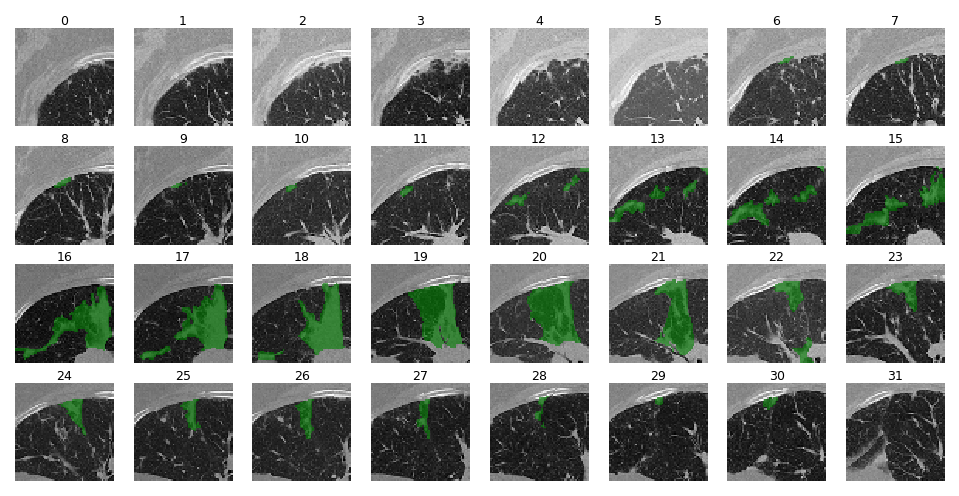

In [23]:
fig=plot_segmentation(i,o)

In [ ]:
#Сохранение сгенерированного обучающего примера и разметки 
afine=np.append(z,0)*np.eye(4)
nib.save(nib.Nifti1Image(i, afine), "ex.nii")
nib.save(nib.Nifti1Image(o, afine), "ex_.nii")

In [158]:
def test_segmentation_function(data):
    """
    Имитирует сегментацию путем создания разметки в форме шара
    """
    a=np.zeros_like(data)
    b=np.meshgrid([i-a.shape[0]/2+0.5 for i in range(a.shape[0])],[i-a.shape[1]/2+0.5 for i in range(a.shape[1])],[i-a.shape[2]/2+0.5 for i in range(a.shape[2])])
    return ((b[0]**2)/((a.shape[0]/2)**2)+(b[1]**2)/((a.shape[1]/2)**2)+(b[2]**2)/((a.shape[2]/2)**2)<=1).astype(np.float32)
    

In [52]:
def segmentation(input_path, volume, grid, func):
    """
    Выполняет полноценну сегментацию с помощью полученной функции, разрезая весь снимок на объемы с заданными параметрами
    """
    volume=np.array(volume)
    grid=np.array(grid)
    
    i=nib.load(input_path)
    zooms=np.array(i.header.get_zooms())
    size=np.array(i.shape)*zooms
    convrter=Сonversion(zooms)
    
    data=i.get_fdata().astype(np.float32)
    fill=data.min()
    ans=np.zeros_like(data)
    
    m_grid=np.floor(size/volume).astype(np.int32)
    padding=(size-m_grid*volume)/2
    v=np.meshgrid(range(m_grid[0]),range(m_grid[1]),range(m_grid[2]))
    
    count=len(v[0].flatten())
    step=0
    for x,y,z in zip(v[0].flatten(),v[1].flatten(),v[2].flatten()):
        step+=1
        #вырезаемый объем
        p=topsIndexsByShape(volume)+np.array([x,y,z])*volume+padding
        p=np.rint(convrter(p)).astype(np.int32)
        if data[tuple(np.rint(p[0]+(p[7]-p[0])/2).astype(np.int32))]==fill:
            continue
        ri=cutDataByAnchorPoints3D(data,grid,p,fill)
        HUmin=-5000; HUmax=5000
        ri=(ri-HUmin)/(HUmax-HUmin)
        ro=func(ri)
        ro=cutDataByAnchorPoints3D(ro,(p[7]-p[0]).astype(np.int32),[],0)
        ans[p[0][0]:p[7][0],p[0][1]:p[7][1],p[0][2]:p[7][2]]=ro
        print(step/count,end="\r",flush=True)
    print("",flush=True)
    return ans, zooms
    
    

In [160]:
# segementation, z = segmentation("trainset/i1.nii",(100,100,100),(64,64,20),test_segmentation_function)
# nib.save(nib.Nifti1Image(segementation, np.append(z,0)*np.eye(4)),"i1_segementation.nii")
nib.save(nib.Nifti1Image(nib.load("trainset/i1.nii").get_fdata(), np.append(z,0)*np.eye(4)),"i1_original.nii")

In [663]:
data=nib.load("trainset/i1.nii").get_fdata()
nib.save(nib.Nifti1Image(data,np.eye(4)),"delete_test_i.nii")